In [1]:
import random

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from time import time
from statistics import mean
from memory_profiler import memory_usage
from scipy.interpolate import griddata

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

from sklearn.utils.fixes import loguniform

%matplotlib inline
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [2]:
# File paths
raw_data_file = '../data/training_data/1992-1997_training_data_raw.csv'
rolling_window_data_file = '../data/training_data/1992-1997_training_data_rolling_window.csv'
daily_mean_data_file = '../data/training_data/1992-1997_training_data_daily_mean.csv'

# Load data
raw_data = pd.read_csv(raw_data_file, low_memory=False)
data_rolling_window = pd.read_csv(rolling_window_data_file, low_memory=False)
data_daily_mean = pd.read_csv(daily_mean_data_file, low_memory=False)

# Shuffel row order
raw_data = raw_data.sample(frac=1).reset_index(drop=True)
data_rolling_window = data_rolling_window.sample(frac=1).reset_index(drop=True)
data_daily_mean = data_daily_mean.sample(frac=1).reset_index(drop=True)

In [3]:
rand_seed = 42
classifier_jobs = 4
optimization_jobs = 4
max_jobs = classifier_jobs * optimization_jobs

sample_size = 5000
train_test_split_ratio = 0.3
cv_folds = 5
n_doublings = 3
scoring_func = make_scorer(f1_score)
grid_search_iterations = 100

plot_grid_resolution = 500
contourf_levels = 500

weather_variables = [
    'air.sfc', 'air.2m', 'apcp', 'crain', 'rhum.2m', 'dpt.2m',
    'pres.sfc', 'uwnd.10m', 'vwnd.10m', 'veg', 'dlwrf', 'dswrf', 
    'lcdc','hcdc', 'mcdc', 'hpbl', 'prate', 'vis', 'ulwrf.sfc'
]

In [4]:
# Functions

def k_random_sample(data, k):
    n = len(data)
    indices = random.sample(range(0, n), k)
    return data.iloc[indices]

def stratified_sample(data, n):
    # split positive and negative datsets up
    ignitions = data[data['ignition'] == 1]
    no_ignitions = data[data['ignition'] == 0]
    
    # Calculate ignition & no ignition sample sizes
    ignition_fraction = len(ignitions) / len(data)
    ignition_sample_size = int((n * ignition_fraction))
    no_ignition_sample_size = int((n * (1 - ignition_fraction)))
    
    # sample data
    no_ignitions_sample = k_random_sample(no_ignitions, no_ignition_sample_size)
    ignitions_sample = k_random_sample(ignitions, ignition_sample_size)

    # combine
    sampled_data = no_ignitions_sample.append(ignitions_sample)
    
    return sampled_data

def cross_validate_classifier(classifier, X_train, y_train, folds, scoring_func):
    cv = StratifiedKFold(n_splits=folds)
    cross_val_scores = cross_val_score(classifier, X_train, y_train, scoring=scoring_func, cv=cv)
    
    return cross_val_scores

def fit_model(classifier, X, y):
    classifier.fit(X, y)
    return classifier

def display_confusion_matrix(classifier, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, classifier.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(
        classifier,
        x_test,
        y_test,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize='true'
    )

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()
    
def calc_false_neg_pos_rate(model, x_test, y_test):
    cm = confusion_matrix(y_test, model.predict(x_test))

    TN = cm[0][0]
    FN = cm[1][0]
    FP = cm[0][1]

    false_neg_rate = FN / (FN + TN)
    false_pos_rate = FP / (FP + TN)
    
    return false_neg_rate, false_pos_rate

def scale_weather_variables(weather_variables, X_train, X_test):

    scaler = StandardScaler()
    scaler.fit(X_train[weather_variables])

    pd.options.mode.chained_assignment = None  # default='warn'
    
    X_train[weather_variables] = scaler.transform(X_train[weather_variables])
    X_test[weather_variables] = scaler.transform(X_test[weather_variables])
    
    pd.options.mode.chained_assignment = 'warn'  # default='warn'
    
    return X_train, X_test

def make_train_test_sample(dataset, sample_size, train_test_split_ratio, rand_seed):
    # Take stratified sample of daily mean data and do stratified test-train split
    
    column_names = dataset.columns
    
    if 'weather_bin_time' in column_names:
        dataset = dataset.drop('weather_bin_time', axis=1)
    
    sampled_data = stratified_sample(dataset, sample_size)

    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y, 
        test_size=train_test_split_ratio, 
        random_state=rand_seed, 
        stratify=y
    )

    return X_train, X_test, y_train, y_test

def FP_rate_scorer(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    false_pos_rate = FP / (FP + TN)
    
    return false_pos_rate

def FN_rate_scorer(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    TN = cm[0][0]
    FN = cm[1][0]
    false_neg_rate = FN / (FN + TN)
    
    return false_neg_rate

def tune_class_weight(
    class_weights,
    max_jobs,
    rand_seed,
    X_train, 
    y_train
):
    
    model_scores_columns = [
        'Class weight',
        'CV F1 score',
        'CV False positive rate',
        'CV False negative rate'
    ]
    
    model_scores = pd.DataFrame(columns=model_scores_columns)

    for class_weight in class_weights:
        
        classifier = XGBClassifier(
            n_jobs = max_jobs,
            scale_pos_weight = class_weight,
            random_state = rand_seed
        )
        
        classifier.fit(X_train, y_train)

        cross_val_scores = cross_validate_classifier(
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            scoring_func
        )
        
        score = mean(cross_val_scores)
        
        cross_val_FP_rates = cross_validate_classifier(
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            make_scorer(FP_rate_scorer)
        ) 
        
        cross_val_FP_rate = mean(cross_val_FP_rates)
        
        cross_val_FN_rates = cross_validate_classifier(
            classifier, 
            X_train, 
            y_train, 
            cv_folds, 
            make_scorer(FN_rate_scorer)
        ) 
        
        cross_val_FN_rate = mean(cross_val_FN_rates)
        
        model_scores = model_scores.append(pd.Series([
            class_weight,
            np.round(score,3), 
            np.round(cross_val_FP_rate,3), 
            np.round(cross_val_FN_rate,3)
        ], index=model_scores.columns), ignore_index=True)

    return model_scores

def tune_hyperparameters(
    classifier,
    param_dist, 
    X_train, 
    y_train, 
    num_jobs, 
    search_iterations, 
    scoring_func
):

    random_search = RandomizedSearchCV(
        classifier, 
        param_distributions=param_dist,
        scoring=scoring_func,
        n_iter=search_iterations,
        n_jobs=num_jobs
    )

    best_model = random_search.fit(X_train, y_train)
    
    return best_model, random_search

def regularize_grid(x, y, z, resolution):

    # target grid to interpolate to
    xi = np.arange(min(x), max(x), ((max(x) - min(x)) / resolution))
    yi = np.arange(min(y), max(y), ((max(y) - min(y)) / resolution))
    xi, yi = np.meshgrid(xi, yi)

    # interpolate
    zi = griddata((x, y), z, (xi, yi), method='linear')
    
    return xi, yi, zi

def display_confusion_matrix(model, class_names, x_test, y_test):

    raw_cm = confusion_matrix(y_test, model.predict(x_test))
    print("Raw count confusion matrix")
    print(raw_cm)
    
    normalized_cm = plot_confusion_matrix(model, x_test, y_test,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues,
                                 normalize='true')

    normalized_cm.ax_.set_title("Normalized confusion matrix")

    plt.show()

In [5]:
# SKLearn classifiers

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier

classifier_descriptions = [
    'Logit. regres.',
    'Decision tree',
    'K neighbors',
    'Rand. forest',
    'QDA',
    'XGBoost',
    'CatBoost',
    'LightGBM',
    'AdaBoost',
    'Linear SVM',
    'RBF SVM',
    'Naive Bayes',
    'Gaussian proc.'
]

# Classifiers with parameters. Set parallism and rand_seed if avalible.
# Also set 'rule of thumb' class weight if avalible for that classifier.

num_negative_observations = len(raw_data[raw_data['ignition'] == 0])
num_positive_observations = len(raw_data[raw_data['ignition'] == 1])
class_ratio = num_negative_observations / num_positive_observations

class_weight_dict = {
    0: (1 / class_ratio),
    1: 1 - (1 / class_ratio)
}

classifiers = (
    
    LogisticRegression(
        n_jobs = max_jobs, 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    DecisionTreeClassifier( 
        random_state = rand_seed,
        class_weight = class_weight_dict
    ),
    
    KNeighborsClassifier(
        n_jobs = max_jobs        
    ),
    
    RandomForestClassifier(
        n_jobs = max_jobs,
        class_weight = class_weight_dict,
        random_state = rand_seed
    ),
    
    QuadraticDiscriminantAnalysis(),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
     AdaBoostClassifier(random_state = rand_seed),
    
    SVC(kernel = "linear",
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    SVC(
        class_weight = 'balanced',
        random_state = rand_seed
    ),
    
    GaussianNB(),
    
    GaussianProcessClassifier(
        n_jobs = max_jobs,
        random_state = rand_seed
    )
)

In [6]:
# Take stratified sample data and do stratified test-train split    
X_train, X_test, y_train, y_test = make_train_test_sample(
    raw_data, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)

In [7]:
# Loop over classifier list, run k-fold cross validation on stratified training sample
# for each. Report mean and SD of score, run time and peak memory use
raw_scores = []
score_means = []
score_sds = []
mem_usages = []
run_times = []

# Start empty dataframe to hold results
classifier_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'CV folds',
    'Raw scores',
    'Mean F1 score',
    'F1 score SD',
    'Peak memory (GB)',
    'Run time (min.)'
])

for classifier, description in zip(classifiers, classifier_descriptions):
    
    start = time()
    
    mem_usage, cross_val_scores = memory_usage((cross_validate_classifier, (
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func)
    ), retval=True)
    
    dT = np.round(((time() - start)/60),2)
    
    raw_scores.append(cross_val_scores)
     
    mean_score = np.round(mean(cross_val_scores),3)
    sd_score = np.round(np.std(cross_val_scores),4)
    max_mem = np.round((max(mem_usage) / 1000),3)
    
    mem_usages.append(max_mem)
    run_times.append(dT)
    score_means.append(mean_score)
    score_sds.append(sd_score)
    
    classifier_data = classifier_data.append(pd.Series([
        description,
        sample_size,
        cv_folds,
        cross_val_scores,
        mean_score,
        sd_score,
        max_mem,
        dT
    ], index=classifier_data.columns), ignore_index=True)
    
classifier_data = classifier_data.sort_values(['Mean F1 score'], ascending=[0])

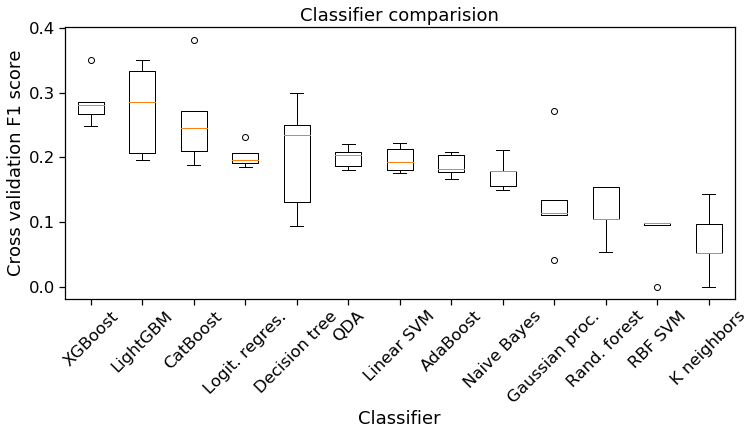

In [8]:
fig = plt.figure(1, figsize=(12, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(classifier_data['Raw scores'])
ax.set_xticklabels(classifier_data['Classifier'])
plt.xlabel('Classifier')
plt.ylabel('Cross validation F1 score')
plt.title('Classifier comparision')
plt.xticks(rotation=45)
plt.show()

In [9]:
classifier_data.drop('Raw scores', axis=1)

,Classifier,Sample size,CV folds,Mean F1 score,F1 score SD,Peak memory (GB),Run time (min.)
5,XGBoost,5000,5,0.287,0.0347,1.691,0.01
7,LightGBM,5000,5,0.275,0.0633,1.725,0.02
6,CatBoost,5000,5,0.260,0.0676,1.722,0.33
0,Logit. regres.,5000,5,0.202,0.0162,1.681,0.04
1,Decision tree,5000,5,0.202,0.0771,1.681,0.00
4,QDA,5000,5,0.200,0.0147,1.691,0.00
9,Linear SVM,5000,5,0.197,0.0177,1.734,0.04
8,AdaBoost,5000,5,0.188,0.0159,1.725,0.03
11,Naive Bayes,5000,5,0.175,0.0217,1.730,0.00
12,Gaussian proc.,5000,5,0.134,0.0754,2.143,0.39


In [10]:
classifier_descriptions = [
    'LightGBM',
    'CatBoost',
    'XGBoost'
]

classifiers = (
    
    LGBMClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    CatBoostClassifier(
        thread_count = max_jobs, 
        silent = True,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
    
    XGBClassifier(
        n_jobs = max_jobs,
        scale_pos_weight = class_ratio,
        random_state = rand_seed
    ),
)

In [11]:
sample_size_data = pd.DataFrame(columns=[
    'Classifier',
    'Sample size',
    'Peak memory (GB)',
    'Run time (min.)'
])

for i in range(0,(n_doublings+1)):
    sampled_data = stratified_sample(raw_data, sample_size)
    sampled_data = sampled_data.drop('weather_bin_time', axis=1)
    y = sampled_data['ignition']
    X = sampled_data.drop('ignition', axis=1)
    
    for classifier, description in zip(classifiers, classifier_descriptions):
        start = time()
        mem_usage, model = memory_usage((fit_model, (classifier, X, y)), retval=True)
        dT = np.round(((time() - start)/60),2)
        
        max_mem = np.round((max(mem_usage) / 1000),3)
        
        sample_size_data = sample_size_data.append(pd.Series([
            description,
            sample_size,
            max_mem,
            dT
        ], index=sample_size_data.columns), ignore_index=True)
    
    sample_size = sample_size * 2

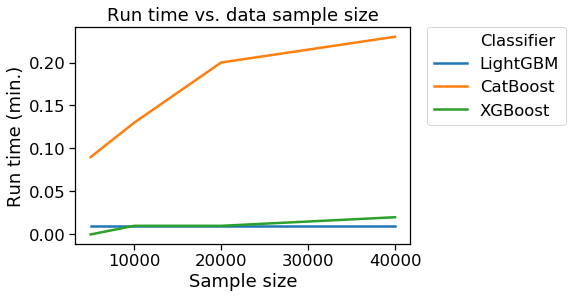

In [12]:
ax = sns.lineplot(x='Sample size', y='Run time (min.)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Run time vs. data sample size')
plt.show()

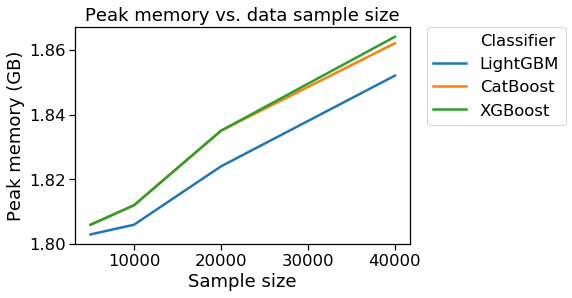

In [13]:
ax = sns.lineplot(x='Sample size', y='Peak memory (GB)', hue='Classifier', data=sample_size_data)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Peak memory vs. data sample size')
plt.show()

Raw count confusion matrix
[[1205  219]
 [  30   46]]


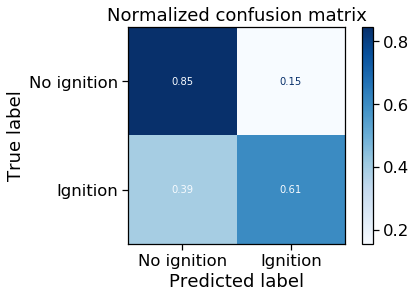

In [14]:
model = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

model.fit(X_train, y_train)

class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(model, class_names, X_test, y_test)

In [15]:
false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(model, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

False negative rate: 0.02
False positive rate: 0.15


In [16]:
# roll data with windowed mean
data_rolling_window = raw_data.iloc[::-1]
data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(6, on="weather_bin_time").mean()
data_rolling_window.reset_index(drop=True, inplace=True)

ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_rolling_window = ignitions.append(no_ignitions)

In [17]:
data_daily_mean = data_rolling_window.groupby([
    'lat', 
    'lon', 
    'weather_bin_year',
    'weather_bin_month',
    'weather_bin_day'
]).mean().reset_index()

data_daily_mean.reset_index(drop=True, inplace=True)

ignitions = data_daily_mean[data_daily_mean['ignition'] > 0].copy()
no_ignitions = data_daily_mean[data_daily_mean['ignition'] == 0].copy()
ignitions['ignition'] = 1

data_daily_mean = ignitions.append(no_ignitions)

In [18]:
# Loop over dataset list, run k-fold cross validation on stratified training sample
# for each. Report raw scores.

dataset_descriptions = [
    "Raw data",
    "Rolling window",
    "Daily average"
]

datasets = (
    raw_data,
    data_rolling_window,
    data_daily_mean
)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
dataset_comparison_results = pd.DataFrame(columns=[
    'Data type',
    'Raw scores',
])
    
for dataset, description in zip(datasets, dataset_descriptions):
    
    X_train, X_test, y_train, y_test = make_train_test_sample(
        dataset, 
        sample_size, 
        train_test_split_ratio, 
        rand_seed
    )
    
    X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)
    
    cross_val_scores = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func
    )
    
    dataset_comparison_results = dataset_comparison_results.append(pd.Series([
        description,
        cross_val_scores,
    ], index=dataset_comparison_results.columns), ignore_index=True)

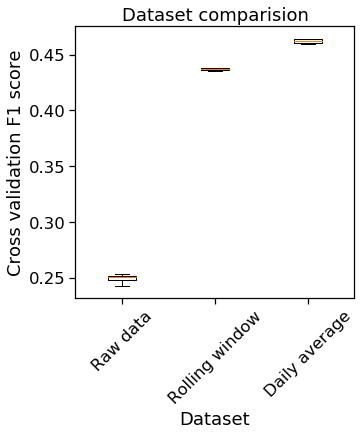

In [19]:
fig = plt.figure(1, figsize=(5, 5))
ax = fig.add_subplot(111)

bp = ax.boxplot(dataset_comparison_results['Raw scores'])
ax.set_xticklabels(dataset_comparison_results['Data type'])
plt.xlabel('Dataset')
plt.ylabel('Cross validation F1 score')
plt.title('Dataset comparision')
plt.xticks(rotation=45)
plt.show()

In [20]:
# Loop over rolling window sizes, run k-fold cross validation on stratified training sample
# for each. Report raw scores, false positive and false negative rates.

window_widths = range(2,26,2)

classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_ratio,
    random_state = rand_seed
)

# Start empty dataframe to hold results
model_scores = pd.DataFrame(columns=[
    'Window width',
    'CV F1 score',
    'CV False positive rate',
    'CV False negative rate'
])

for window_width in window_widths:
    
    # Reverse and roll data with window width
    data_rolling_window = raw_data.iloc[::-1]
    data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(window_width, on="weather_bin_time").mean()
    data_rolling_window.reset_index(drop=True, inplace=True)
    
    ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
    no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
    ignitions['ignition'] = 1

    dataset = ignitions.append(no_ignitions)
    
    X_train, X_test, y_train, y_test = make_train_test_sample(
        dataset, 
        sample_size, 
        train_test_split_ratio, 
        rand_seed
    )
    
    X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)
    
    cross_val_scores = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        scoring_func
    )

    score = mean(cross_val_scores)

    cross_val_FP_rates = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        make_scorer(FP_rate_scorer)
    ) 

    cross_val_FP_rate = mean(cross_val_FP_rates)

    cross_val_FN_rates = cross_validate_classifier(
        classifier, 
        X_train, 
        y_train, 
        cv_folds, 
        make_scorer(FN_rate_scorer)
    ) 

    cross_val_FN_rate = mean(cross_val_FN_rates)

    model_scores = model_scores.append(pd.Series([
        window_width,
        np.round(score,3), 
        np.round(cross_val_FP_rate,3), 
        np.round(cross_val_FN_rate,3)
    ], index=model_scores.columns), ignore_index=True)

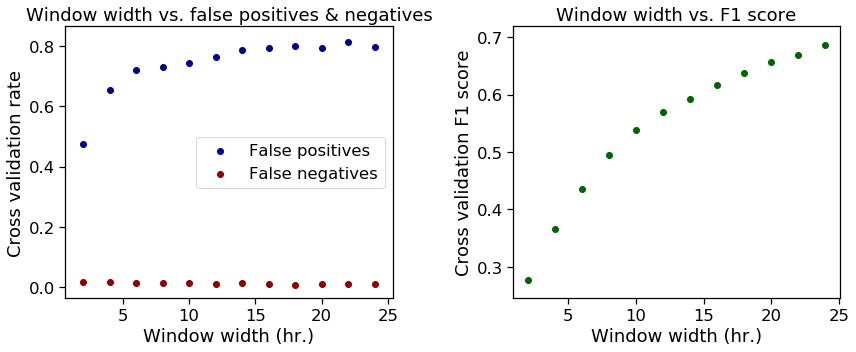

In [21]:
plt.subplots(1,2,figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(
    model_scores['Window width'], 
    model_scores['CV False positive rate'],
    color = "darkblue",
    label = 'False positives'
)
plt.scatter(
    model_scores['Window width'], 
    model_scores['CV False negative rate'],
    color = "darkred",
    label = 'False negatives'
)
plt.xlabel('Window width (hr.)')
plt.ylabel('Cross validation rate')
plt.title('Window width vs. false positives & negatives')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    model_scores['Window width'], 
    model_scores['CV F1 score'],
    color = "darkgreen",
    label ='CV F1 score',
)
plt.xlabel('Window width (hr.)')
plt.ylabel('Cross validation F1 score')
plt.title('Window width vs. F1 score')

plt.tight_layout()
plt.show()

In [22]:
# Reverse and roll data with window width
data_rolling_window = raw_data.iloc[::-1]
data_rolling_window = data_rolling_window.groupby(['lat', 'lon']).rolling(6, on="weather_bin_time").mean()
data_rolling_window.reset_index(drop=True, inplace=True)

ignitions = data_rolling_window[data_rolling_window['ignition'] > 0].copy()
no_ignitions = data_rolling_window[data_rolling_window['ignition'] == 0].copy()
ignitions['ignition'] = 1

dataset = ignitions.append(no_ignitions)

X_train, X_test, y_train, y_test = make_train_test_sample(
    dataset, 
    sample_size, 
    train_test_split_ratio, 
    rand_seed
)

X_train, X_test = scale_weather_variables(weather_variables, X_train, X_test)

In [23]:
class_weights = np.logspace(-2, 3, num=25, base=10)

model_scores = tune_class_weight(
    class_weights,
    max_jobs,
    rand_seed,
    X_train, 
    y_train
)

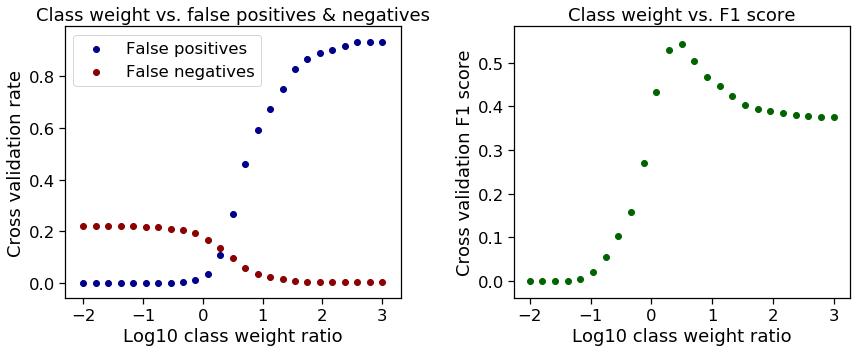

In [24]:
plt.subplots(1,2,figsize=(12,5))

plt.subplot(1, 2, 1)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV False positive rate'],
    color = "darkblue",
    label = 'False positives'
)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV False negative rate'],
    color = "darkred",
    label = 'False negatives'
)
plt.xlabel('Log10 class weight ratio')
plt.ylabel('Cross validation rate')
plt.title('Class weight vs. false positives & negatives')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(
    np.log10(model_scores['Class weight']), 
    model_scores['CV F1 score'],
    color = "darkgreen",
    label ='CV F1 score',
)
plt.xlabel('Log10 class weight ratio')
plt.ylabel('Cross validation F1 score')
plt.title('Class weight vs. F1 score')

plt.tight_layout()
plt.show()

In [25]:
model_scores = model_scores.sort_values(['CV F1 score'], ascending=[0])
model_scores.reset_index(drop=True, inplace=True)
class_weight = model_scores.loc[0,'Class weight']

In [31]:
class_weight

3.1622776601683795

In [26]:
classifier = XGBClassifier(
    n_jobs = classifier_jobs,
    scale_pos_weight = class_weight,
    random_state = rand_seed
)

param_dist = {
    'learning_rate': loguniform(0.0001, 1),
    'n_estimators': range(1,200)
}

best_model, random_search = tune_hyperparameters(
    classifier,
    param_dist, 
    X_train, 
    y_train, 
    optimization_jobs, 
    grid_search_iterations, 
    scoring_func
)


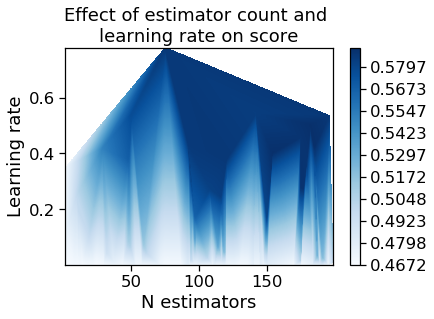

In [27]:
rand_search_results = pd.DataFrame(random_search.cv_results_).dropna()

x = rand_search_results['param_n_estimators']
y = rand_search_results['param_learning_rate']
z = rand_search_results['mean_test_score']
xi, yi, zi = regularize_grid(x, y, z, plot_grid_resolution)

sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

plt.contourf(xi, yi, zi, contourf_levels, cmap=plt.cm.Blues)
plt.xlabel("N estimators")
plt.ylabel("Learning rate")
plt.title("Effect of estimator count and \nlearning rate on score")
plt.colorbar()
plt.show()

In [28]:
best_learning_rate = rand_search_results.iloc[0]['param_learning_rate']
best_n_estimators = rand_search_results.iloc[0]['param_n_estimators']

Raw count confusion matrix
[[18422   284]
 [ 4609   685]]


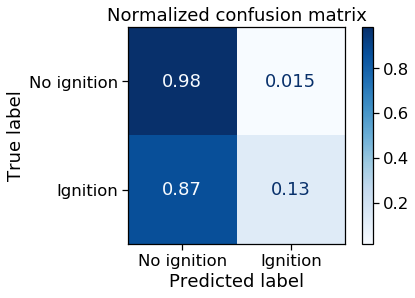

In [35]:
classifier = XGBClassifier(
    n_jobs = max_jobs,
    scale_pos_weight = class_weight,
    learning_rate = best_learning_rate,
    n_estimators = best_n_estimators,
    random_state = rand_seed
)

classifier.fit(X_train, y_train)

class_names = np.array(['No ignition', 'Ignition'])
display_confusion_matrix(classifier, class_names, X_test, y_test)

In [30]:
false_neg_rate, false_pos_rate = calc_false_neg_pos_rate(classifier, X_test, y_test)
print("False negative rate: {}".format(np.round(false_neg_rate, 2)))
print("False positive rate: {}".format(np.round(false_pos_rate, 2)))

False negative rate: 0.08
False positive rate: 0.47
